<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/32_TensorFlow_customization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TensorFlow Customization**

https://www.tensorflow.org/guide/basic_training_loops

So far in this, we used methods provided by build in TF APIs like tf.keras and tf.Estimator. While these constructs are sufficient to start any AI project, there could be situations where you may have to implement custom models, loss function or metrics. Tensorflow 2.0 provides support for extending its functionality. In this, we will learn how to customize TF 2.0 functionality.

This is an introductory TensorFlow that shows how to:
*  Import the required package
*  Create and use tensors
*  Use GPU acceleration
*  Demonstrate `tf.data.Dataset`

## **Import TensorFlow**
To get started, import the `tensorflow` module. As of TensorFlow 2, eager execution is turned on by default. This enables a more interactive fronted to Tesorflow, the details of which we will discuss much later

In [ ]:
import tensorflow as tf

## **Tensor**
A Tensor is a multi-dimensional array. Similar to NumPy `ndarray` objects, `tf.tensor` objects have a data type and a shape. Additionally, `tf.Tensor`s can reside in accelerator memory (like a GPU). TensorFlow offers a rich library of operations ([tf.add ](https://www.tensorflow.org/api_docs/python/tf/math/add), [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul), [tf.linalg.inv](https://www.tensorflow.org/api_docs/python/tf/linalg/inv) etc.) that consume and produce `tf.Tensor`s. These operations automatically convert native Python types, for example:

In [ ]:
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

# Operatior overloading is also supported
print(tf.square(2) + tf.square(3))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


Each `tf.Tensor` has a shape and a datatype.

In [ ]:
x = tf.matmul([[1]], [[2, 3]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
(1, 2)
<dtype: 'int32'>


The most obvious different between NumPy array and `tf.Tensor`s are:
1. Tensors can be backed by accelerator memory(like GPU, TPU).
2.  Tensors are immutable.

## NumPy Compatibility
Converting between a TensorFlow [`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor)s and a Numpy `ndarray` is easy:

*  TensorFlow operations automatically convert NumPy ndarray to Tensors.
*  NumPy operations automatically convert Tensors to NumPy ndarrays.

Tensors are expilcitly convert to NumPy ndarrays using their `.numpy` method. These conversions are typically cheap since the array and `tf.tensor` share the underlying memory representation, if possible. However, sharing the underlying representation isn't always possible since the `tf.Tensor` may be hosted in GPU memory while NumPy arrays are always backed by host memory, and the conversion involves a copy from GPU TO host memory.

In [ ]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to tensors automatically")
tensor = tf.multiply(ndarray, 42)
print(tensor)

print("And NumPy operations convert Tensors to numpy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

TensorFlow operations convert numpy arrays to tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
And NumPy operations convert Tensors to numpy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]


# **GPU acceleration**

Many TensorFlow operations are accelerated using the GPU for computation. Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation-copying the tensor between CPU and GPU memory, if necessary. Tensors produces by an operation are typically backed by the memory of the device on which the operation executed, for example:


In [ ]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: ")
print(tf.config.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0: ")
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0: 
True


## Device Name

The `Tensor.device` property provides a fully qualified string name of the device hosting the contents of the tensor. This name encodes many details, such as an identifier of the network address of the host on which this program is executing and the device with that host. This is required for distributed execution of a TensorFlow program. The string endsnwith `GPU:<N>` if the tensor is placed on the `N`-th GPU on the host.

## Explicit Deice Placement
In TensorFlow, *placement* refers to how individual operations are assigned (placed on) a device for execution. As mentioned, when there is no explicit guidance provided, TensorFlow automatically decides which device to execute an operation and copies tensors to specific devices using the `tf.device` context manager, for example:

In [ ]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start

  print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.config.list_physical_devices("GPU"):
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

On CPU:
10 loops: 322.93ms
On GPU:
10 loops: 555.51ms


## Datasets
This section uses the `tf.data.Dataset API` to build a pipeline for feeding data to your model. The `[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)` API is used to build performant, complex input pipeline from simple, reusable pieces that will feed your model's training or evaluation loops.

## Create a sourse **Dataset**
Create a *source* dataset  using one of the factory functions like `Dataset.from_tensors, Dataset.from_tensor_slices`, or using objects that read from files like `TextLineDataset` or `TFRecordDataset`. See the *TensorFlow Dataset guide* for more information

In [ ]:
ds_tensors = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])

# Create a CSV file
import tempfile
_, filename = tempfile.mkstemp()

with open(filename, 'w') as f:
  f.write("""Line 1
  Line 2
  Line 3
    """)
  
ds_file = tf.data.TextLineDataset(filename)

## Apply transformations
Use the transformation functions like `map`, `batch`, and 'shuffle' to apply transformations to dataset records.

In [ ]:
ds_tensors = ds_tensors.map(tf.square).shuffle(2).batch(2)

ds_file = ds_file.batch(2)

## Iterate
`tf.data.Dataset` objects support iteration to loop over record:

In [ ]:
print('Elements of ds_tensor:')
for x in ds_tensors:
  print(x)

print('\nElement in ds_file:')
for x in ds_file:
  print(x)

Elements of ds_tensor:
tf.Tensor([1 9], shape=(2,), dtype=int32)
tf.Tensor([16  4], shape=(2,), dtype=int32)
tf.Tensor([36 25], shape=(2,), dtype=int32)

Element in ds_file:
tf.Tensor([b'Line 1' b'  Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'  Line 3' b'    '], shape=(2,), dtype=string)


Customization opportunities:
*  Model
*  Loss function
*  Training Loop
*  Metrics

Let's learn how we can carry out this customizations. 

## **Writing custom layers**
Layers provide higher level of abstraction for implementing ML models. Many machine learning models are expressible as the composition and stacking of relatively simple layers, and TensorFlow provides both a set of many common layers as a well as easy ways for you to write your own application-specific layers either from  scratch or as the composition of existing layers.



In [ ]:
# In the tf.keras.layers package, layers are objects. To construct a layer,
# simply construct the object. Most layers take as a first argument the number
# of output dimensions / channels.
layer = tf.keras.layers.Dense(100)

# The number of input dimensions is often unncessary, as it can be inferred
# the first time the layer is used, but it can be provided if you want to
# specify it manually, which is useful in some complex models.
layer = tf.keras.layers.Dense(10, input_shape=(None, 5))

Example layers are Dense (a fully-connected layer), Conv2D, LSTM, BatchNormalization, Dropout, and many others.  

In [ ]:
# To use a layer, simply call it.
layer(tf.zeros([10, 5]))

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Layer have many useful methods. For example, you can inspect all variables
# in a layer using 'layer.variables' and trainable variables using 
# 'layer.trainable_variable'. In this case a fully-connected layer
# will have variables for weights and biases.
layer.variables

[<tf.Variable 'dense_1/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[ 0.20905888, -0.38080052,  0.16276693,  0.5383629 ,  0.21442747,
          0.13619864,  0.26666003, -0.19832075,  0.0180136 ,  0.07614654],
        [-0.37919158, -0.13683435,  0.2078464 ,  0.2016176 ,  0.07687306,
         -0.12600166,  0.21432263,  0.21049851,  0.5052528 , -0.13991001],
        [-0.35853574,  0.04692966,  0.31038183, -0.62749124,  0.28959072,
          0.6207351 , -0.54864764, -0.50891596, -0.19068405,  0.21181697],
        [ 0.1098609 , -0.00665313, -0.3480743 , -0.54486316,  0.23866546,
         -0.38540816, -0.32521918,  0.23735994,  0.00598317,  0.28228468],
        [-0.13930655, -0.13956425,  0.46567613, -0.60738593, -0.51548266,
          0.02628058,  0.3067608 , -0.20731413, -0.16830602,  0.14127237]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [ ]:
# The variables are also accessible through nice accessors
layer.kernel, layer.bias

(<tf.Variable 'dense_1/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[ 0.20905888, -0.38080052,  0.16276693,  0.5383629 ,  0.21442747,
          0.13619864,  0.26666003, -0.19832075,  0.0180136 ,  0.07614654],
        [-0.37919158, -0.13683435,  0.2078464 ,  0.2016176 ,  0.07687306,
         -0.12600166,  0.21432263,  0.21049851,  0.5052528 , -0.13991001],
        [-0.35853574,  0.04692966,  0.31038183, -0.62749124,  0.28959072,
          0.6207351 , -0.54864764, -0.50891596, -0.19068405,  0.21181697],
        [ 0.1098609 , -0.00665313, -0.3480743 , -0.54486316,  0.23866546,
         -0.38540816, -0.32521918,  0.23735994,  0.00598317,  0.28228468],
        [-0.13930655, -0.13956425,  0.46567613, -0.60738593, -0.51548266,
          0.02628058,  0.3067608 , -0.20731413, -0.16830602,  0.14127237]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

## **Implementing custom layers**
The best way to implement your own layer is extending the tf.keras.Layer class and implementing:
*  `__init__` , where you can do all input-independent initialization
*  `build`, where you know the shapes of the input tensors and can do the rest of the initialization
*  `call` where you do the forward computation

Note that you don't have to wait until `build` is called to create your variables, you can also create them in `__init__`. However,
*  The advantage of creating them in build is that it enables **late variable creation** based on the shape of the inputs the layer will operate on.
*  On the other hand, creating variable in `__init__` would mean that **shapes required to create the variables will need to be explicitly specified.**

In [ ]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]),
                                         self.num_outputs])

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel)


layer = MyDenseLayer(10)
print(layer(tf.zeros([10, 5])))
print()
print(layer.trainable_variables)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)

[<tf.Variable 'my_dense_layer/kernel:0' shape=(5, 10) dtype=float32, numpy=
array([[ 0.35589224, -0.5360265 ,  0.06197554, -0.27925608, -0.28954425,
        -0.49069637, -0.05750704,  0.27957845,  0.13759267, -0.14388767],
       [-0.04361773, -0.46767148, -0.25190127,  0.3751964 , -0.35982844,
         0.11592895,  0.6024315 ,  0.4936903 ,  0.58209175,  0.35252905],
       [-0.579371  ,  0.54324216, -0.21697927,  0.12442183,  0.21087438,
        -0.45649394, -0.16855815, -0.22220168,  0.24416113,  0.28396434],
       [ 0.40663797, -0.5538128 ,  0.2517696 , -0.48818755, -0.5996393 ,
        -0.27014676, -0.4788531 ,  

## **Automatic Differentiation**
Automatic differentiation is a key technique for optimizing ML models.

### **Gradient tapes**
TenorFlow provides the `tf.GradientTape` API for automatic differentiation - computing the gradient of a computation with respect to its input variables.
*  Tensorflow "records" all operations executed inside the context of a tf.GradientTape onto a "tape"
*  Tensorflow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using `reverse mode differentiation.`

For each example shown here, we will construct a computation graph and work out the derivatives. We compare the manually calculated derivatives with automatic differentiation.

Any computation wrapped in a tape is recorded, and after the operations have happended you can request gradients from any Tensor to any variable.

In [ ]:
x = tf.Variable(1.0)
with tf.GradientTape() as tape:
  y = x ** 2
  z = y ** 2
dz_dx, dz_dy = tape.gradient(z, [x, y])
print(dz_dx.numpy()) # 4.0
print(dz_dy.numpy()) # 2.0

4.0
2.0


If you want to request a gradient from a tensor to another tensor, then you need to tell the tape to watch the source tensor:

In [ ]:
x = tf.constant(1.0)
with tf.GradientTape() as tape:
  tape.watch(x) # Since 'x' is not a variable we must explicitly "watch" it.
  y = x ** 2
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy()) # 2.0

2.0


By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. To compute multiple gradients over the same computaion, create a presistent gradient tape. This allows multiple calls to the gradient() method as resources are released when the tape object is gargbage collected. For example:

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y
dz_dx = t.gradient(z, x) # 108.8 (4*x^3 at x == 3)
dy_dx = t.gradient(y, x) # 6.0

print(dy_dx)
print(dz_dy)
print(dz_dx)

del t # Drop the reference to the tape

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(108.0, shape=(), dtype=float32)


## **Recording control flow**
Because tapes record operations as they are executed, Python control flow (using ifs and whiles for example) in naturally handled:

In [ ]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

assert grad(x, 6).numpy() == 12.0
assert grad(x, 5).numpy() == 12.0
assert grad(x, 4).numpy() == 4.0

## **Higher-order gradients**
Operations inside of the GradientTape context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradient as well. For example:

In [ ]:
x = tf.Variable(1.0) # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
    # Compute the gradient inside the 't' context manager
    # which mean the gradient computation if differentiable as well.
    dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0


In This section, we covered gradient computation in TensorFlow. With that we have enough of the primitives required to build and train neural networks.

## **Custom Training**
Let's train neural networks from the first principle so as to acquire strong foundation understanding of the concepts. We use tf.Variable to represent weights in a model. A tf.Variable object stores a value and implicitly reads from this stored value. These are operatons (tf.assign_sub,tf.scatter_update. etc.) that manipulate the value stored in a TensorFlow variable.

In [ ]:
 v = tf.Variable(1.0)
 # Use Python's 'assert' as a debugging statement to test the condition
 assert v.numpy() == 1.0

 # Reassign the value 'v'
 v.assign(3.0)
 assert v.numpy() == 3.0

 # Use 'v' in a Tensorflow 'tf.square()' operation and reassign
 v.assign(tf.square(v))
 assert v.numpy() == 9.0

## **Fit a linear model**
Let's use the concepts you have learned so far-Tensor, Variable, and GradientTape-to build and train a simple model. This typically involves a few steps:
1.  Define the model.
2.  Define a loss function.
3.  Obtain training data.
4.  Run through the training data and use an "optimizer" to adjust the variable to fit the data.

Here, you'll create a simple linear model, f(x) = x * W + b, which has two variables: W(weights) and b(bias). You'll synthesize data such that a well trained model would have W = 3.0 and b = 2.0.

## **Define the model**
Let's define a simple class to encapsulate the variables and the computation:

In [ ]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be randomly initialized
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# List the variables tf.modules's built-in variable aggregation.
print("Variables:", model.variables)

# Verify the model works
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


## **Define a loss function**
A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Let's use the standard L2 loss, also known as the least square errors:

In [ ]:
# This computes a single loss value for an entire batch
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

## **Obtain training data**
First, synthesize the training data by adding random Gaussian (Normal) noise to the inputs:

In [ ]:
# The actual line
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# A vector of random x values
x = tf.random.normal(shape=[NUM_EXAMPLES])

# Generate some noise
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# Calculate y
y = x * TRUE_W + TRUE_B + noise

Before training the model, visualie the loss value by plotting the model's predictions in red and the training data im blue:

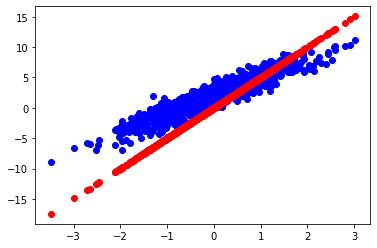

Current loss: 9.091275


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x, y, c = 'b')
plt.scatter(x, model(x), c = 'r')
plt.show()

print('Current loss: %1.6f' % loss(model(x), y).numpy())

## **Define a training loop**
With the network and training data, train the model using gradient descent to update the weights variable (W) and the bias variable (b) to reduce the loss. There are many of the gradient descent scheme that are captured in `tf.train.Optimizer-`our recommended implementation. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines tf.assign and tf.sub):

In [ ]:
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

Finally, let's repeatedly run through the training data and see how W and b evolve.

In [ ]:
model = MyModel()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)

# Define a training loop
def training_loop(model, x, y):

  for epoch in epochs:
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)

    # Track this before I update
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" %
          (epoch, Ws[-1], bs[-1], current_loss))

Starting: W=5.00 b=0.00, loss=9.09128
Epoch  0: W=4.62 b=0.41, loss=6.26713
Epoch  1: W=4.30 b=0.73, loss=4.43387
Epoch  2: W=4.05 b=0.99, loss=3.24357
Epoch  3: W=3.85 b=1.20, loss=2.47056
Epoch  4: W=3.68 b=1.37, loss=1.96843
Epoch  5: W=3.54 b=1.50, loss=1.64219
Epoch  6: W=3.43 b=1.61, loss=1.43018
Epoch  7: W=3.34 b=1.69, loss=1.29237
Epoch  8: W=3.27 b=1.76, loss=1.20277
Epoch  9: W=3.21 b=1.82, loss=1.14451


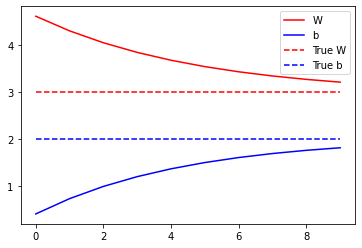

In [ ]:
print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" %
      (model.w, model.b, loss(y, model(x))))

# Do the training
training_loop(model, x, y)

# Plot it
plt.plot(epochs, Ws, "r",
         epochs, bs, "b")

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_B] * len(epochs), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()

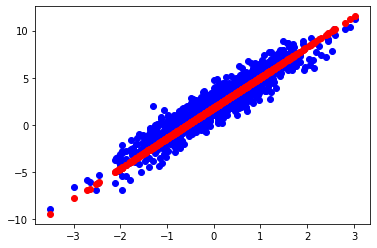

Current loss: 1.144507


In [ ]:
# Visualize how the trained model performs
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())